In [1]:
using Pkg
pkg"activate ."

In [10]:
using PerlaTonettiWaugh, Plots, BenchmarkTools

# Steady states

## Solving steady state solutions

Set up parameters and find the corresponding stationary solution:

In [30]:
# Define common objects. 
parameters = parameter_defaults()

settings = settings_defaults()
settings = merge(settings, (global_transition_penalty_coefficient = 1.0, ))
z_grid = settings.z
M = length(z_grid)

d_0 = parameters.d_0
d_T = parameters.d_T
params_0 = merge(parameters, (d = d_0,)) # parameters to be used at t = 0
params_T = merge(parameters, (d = d_T,)) # parameters to be used at t = T

# solve for stationary solution at t = 0
stationary_sol_0 = stationary_numerical(params_0, z_grid) # solution at t = 0
stationary_sol = stationary_numerical(params_T, z_grid) # solution at t = T

Ω_0 = stationary_sol_0.Ω;
Ω_T = stationary_sol.Ω;

## Welfare in steady states

### Steady state at `T`

In [31]:
display_stationary_sol(stationary_sol);

g = 0.02061571022163528
z_hat = 1.4039337093174584
Ω = 1.256289914815114
y = 1.3124933042070521
c = 1.3124933042070521
U_bar = getfield(PerlaTonettiWaugh, Symbol("##21#22")){Float64,Float64,Float64,Float64}(0.02061571022163528, 0.02, 1.0, 1.3124933042070521)
λ_ii = 0.7552342507764566
L_tilde = 0.2099540512300403
z_bar = 1.661287303922642
w = 0.41640447762247895
x = 1.0
π_min = 0.05794255714339016
r = 0.09361571022163528
a = 9.160936806822816
b = 0.1424454938335876
S = 0.03389742139851562


### Steady state at `0`

In [32]:
display_stationary_sol(stationary_sol_0);

g = 0.010930652407446461
z_hat = 1.813536131532248
Ω = 1.7797899972309776
y = 1.421579400815011
c = 1.421579400815011
U_bar = getfield(PerlaTonettiWaugh, Symbol("##21#22")){Float64,Float64,Float64,Float64}(0.010930652407446461, 0.02, 1.0, 1.421579400815011)
λ_ii = 0.8982453618464044
L_tilde = 0.19292029407989145
z_bar = 1.761386626856568
w = 0.4414945425247063
x = 1.0
π_min = 0.0496931065015285
r = 0.08393065240744646
a = 12.468098349328484
b = 0.14906085730843088
S = -0.011680460675056958


# Transition dynamics

Setup for optimizer:

In [33]:
settings = merge(settings, (params_T = params_T, stationary_sol_T = stationary_sol, Ω_0 = Ω_0));

Find the corresponding solution (should take about 20s to run)

In [34]:
@time result = solve_full_model_nlopt(settings)
solved = result.solution;
E_nodes = result.E_nodes;

108.429330 seconds (152.65 M allocations: 206.423 GiB, 32.06% gc time)


In [16]:
println("E_nodes (sorted) : ")
sort(E_nodes)

E_nodes (sorted) : 


14-element Array{Float64,1}:
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0

## Plots for Ω and `entry_residuals`

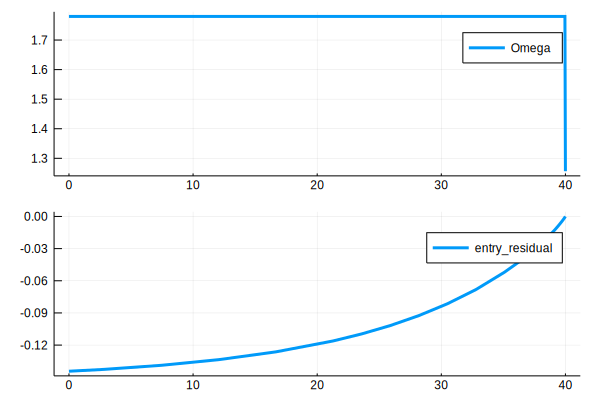

In [17]:
solved = solved.results;
plot_Ω = plot(solved.t, solved.Ω, label = "Omega", lw = 3)
plot_residual = plot(solved.t, solved.entry_residual, label = "entry_residual", lw = 3)
plot(plot_Ω, plot_residual, layout = (2,1))

## Primary Plots

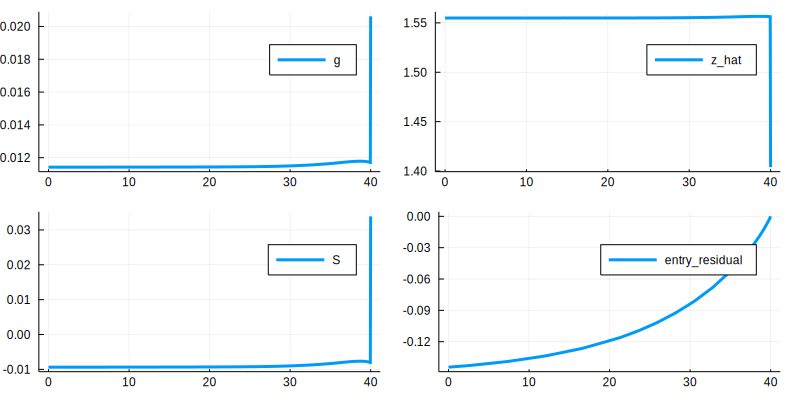

In [23]:
plot1 = plot(solved.t, solved.g, label = "g", lw = 3)
plot2 = plot(solved.t, solved.z_hat, label = "z_hat", lw = 3)
plot3 = plot(solved.t, solved.S, label = "S", lw = 3)
plot4 = plot(solved.t, solved.entry_residual, label = "entry_residual", lw = 3)
plot(plot1, plot2, plot3, plot4, layout=(2,2), size = (800, 400))

## Static Equations

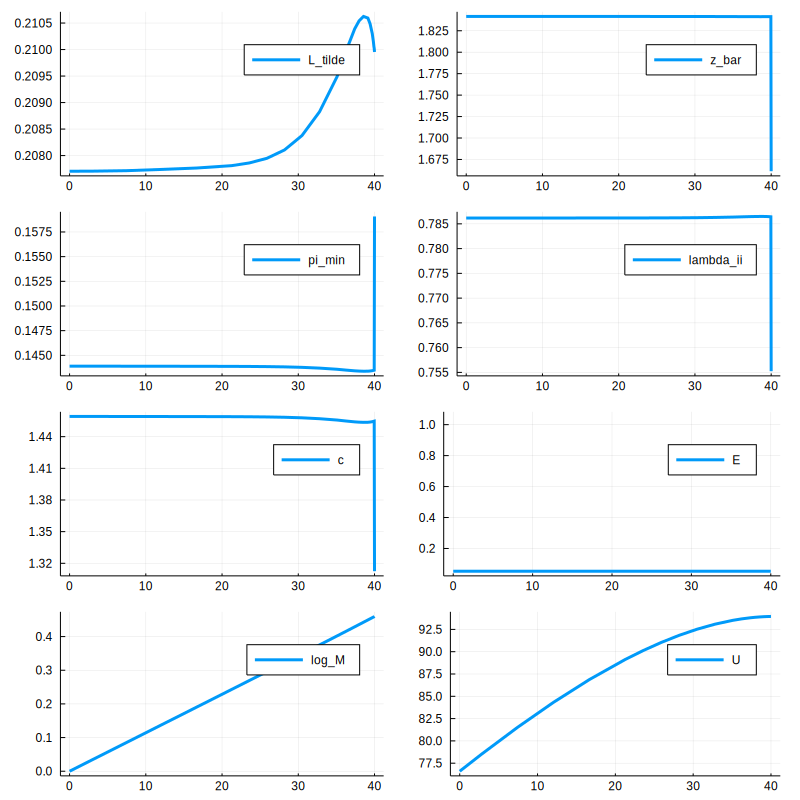

In [20]:
plot1 = plot(solved.t, solved.L_tilde, label = "L_tilde", lw = 3)
plot2 = plot(solved.t, solved.z_bar, label = "z_bar", lw = 3)
plot3 = plot(solved.t, solved.π_min, label = "pi_min", lw = 3)
plot4 = plot(solved.t, solved.λ_ii, label = "lambda_ii", lw = 3)
plot5 = plot(solved.t, solved.c, label = "c", lw = 3)
plot6 = plot(solved.t, solved.E, label = "E", lw = 3)
plot7 = plot(solved.t, solved.log_M, label = "log_M", lw = 3)
plot8 = plot(solved.t, solved.U, label = "U", lw = 3)
plot(plot1, plot2, plot3, plot4, plot5, plot6, plot7, plot8, layout=(4,2), size = (800, 800))

# Welfare analysis

### `log_M(t)`

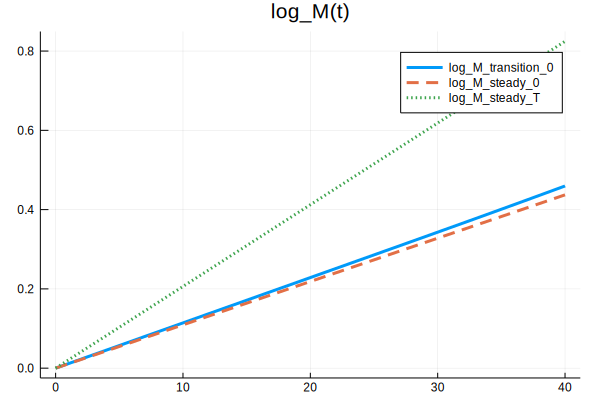

In [24]:
# define log_M with steady state g
log_M_steady_0(t) = stationary_sol_0.g * t
log_M_steady_T(t) = stationary_sol.g * t

# generate the plot!
plot(solved.t, 
    [solved.log_M, log_M_steady_0, log_M_steady_T], 
    label = ["log_M_transition_0", "log_M_steady_0", "log_M_steady_T"] ,
    title = "log_M(t)", linestyle = :auto, lw = 3)

### `Ω(t)`

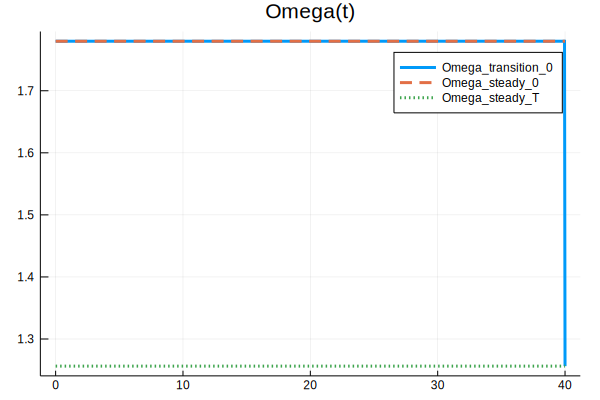

In [25]:
# define Ω function (constant)
Ω_steady_0(t) = stationary_sol_0.Ω
Ω_steady_T(t) = stationary_sol.Ω

# generate the plot!
plot(solved.t, 
    [solved.Ω, Ω_steady_0, Ω_steady_T], 
    label = ["Omega_transition_0", "Omega_steady_0", "Omega_steady_T"] ,
    title = "Omega(t)", linestyle = :auto, lw = 3)

### `c(t)`

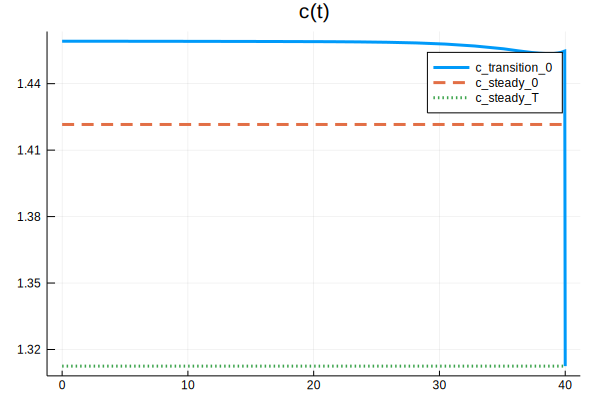

In [26]:
# define c function (constant)
c_steady_0(t) = stationary_sol_0.c
c_steady_T(t) = stationary_sol.c

# generate the plot!
plot(solved.t, 
    [solved.c, c_steady_0, c_steady_T], 
    label = ["c_transition_0", "c_steady_0", "c_steady_T"] ,
    title = "c(t)", linestyle = :auto, lw = 3)

### `U(t)`

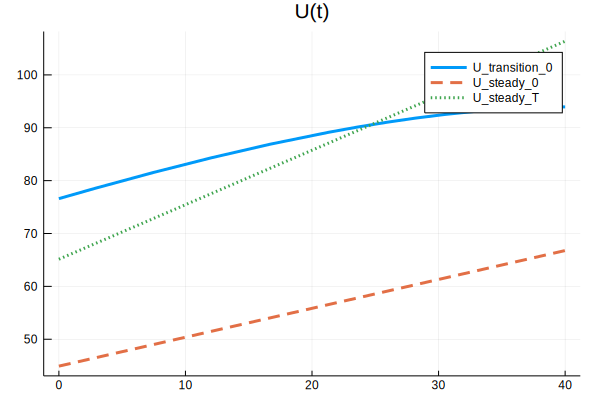

In [27]:
# generate the plot!
plot(solved.t, 
    [solved.U, stationary_sol_0.U_bar, stationary_sol.U_bar], 
    label = ["U_transition_0", "U_steady_0", "U_steady_T"] ,
    title = "U(t)", linestyle = :auto, lw = 3)

## Consumption equivalent for search threshold (`M(0)`)
See computational appendix for details.

### `M(0)` by two steady states (autarky and steady state at `T`)

In [28]:
T = solved.t[end]
consumption_equivalent(solved.U[end], stationary_sol_0.U_bar(T), params)

1.7220113831581494

### `M(0)` by autarky and transition from `t=0`

In [29]:
T = solved.t[end]
consumption_equivalent(solved.U[1], stationary_sol_0.U_bar(T), params)

1.2170910702223292

### Continuation Approach

The cell below takes a while to run, but is a relatively robust way to get the solution. 

In [ ]:
#=    solve_continuation(3.07, # d_0 value
                        2.5019, # d_T value
                        step = 0.001, # default is 0.005 
                        params = parameter_defaults(), 
                        settings = settings_defaults(),
                        solver = solve_full_model_newuoa) # default is solve_full_model_python
=#